# Boundary Value Problems

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Finite difference method:

In [2]:
def thomas_algorithm(A, f):
    """
    Solves system of linear equations with tridiagonal matrix using Thomas' algorithm.
    Args:
        A (array_like): A n-by-n regular matrix
        f (array_like): RHS vector of size n
    Returns:
        numpy.ndarray: Vector of solution
    """
    n, n = A.shape # get the size of input matrix
    c = np.diag(A, -1) # get elements below diagonal 
    a = np.diag(A, 0) # get elements on diagonal
    b = np.diag(A, 1) # get elements above diagonal
    c = np.insert(c, 0, 0.0) # insert 0 as a first element of c
    b = np.insert(b, b.size, 0.0) # insert 0 as a last element of b
    x = np.zeros(n+1) 
    rho = np.zeros(n+1)
    mu  = np.zeros(n+1)
    for i in range(0, n):
        mu[i] = -b[i] / (c[i] * mu[i-1] + a[i])
        rho[i] = (f[i] - c[i] * rho[i-1]) / (c[i] * mu[i-1] + a[i])
    for i in range(n-1, -1, -1):
        x[i] = mu[i] * x[i+1] + rho[i]
    return x[:-1]

In [3]:
def finite_difference_method(a, b, n, p, q, r, s, alpha, beta):
    """
    Solves 2nd order linear ODE in the form p(x)y(x)'' + q(x)y(x)' + r(x)y(x) + s(x) = 0 in [a, b] with y(a) = alpha,
    y(b) = beta using finite difference method.
    Args:
        a (float): The left-most point of the interval
        b (float): The right-most point of the interval
        n (int): Number of points dividing interval [a, b]
        p (function): Arbitrary differentiable function
        q (function): Arbitrary differentiable function
        r (function): Arbitrary differentiable function
        s (function): Arbitrary differentiable function
        alpha (float): Initial value at x = a
        beta (float): Initial value at x = b
    Returns:
        numpy.ndarray: Vector of grid-points
        numpy.ndarray: Vector of solution
    """
    x, h = np.linspace(a, b, n, retstep=True)
    A = np.zeros((n-2, n-2))
    b = np.zeros(n-2)
    for i in range(n-2):
        if i == 0:
            A[i][i] = -2.0 * p(x[i]) + r(x[i]) * h**2
            A[i][i+1] = p(x[i]) + q(x[i]) * h / 2.0 
            b[i] = -s(x[i]) * h**2 - (p(x[i]) - q(x[i]) * h / 2.0) * alpha
        elif i == n-3:
            A[i][i-1] = p(x[i]) - q(x[i]) * h / 2.0
            A[i][i] = -2.0 * p(x[i]) + r(x[i]) * h**2 
            b[i] = -s(x[i]) * h**2 - (p(x[i]) + q(x[i]) * h / 2.0) * beta
        else:
            A[i][i-1] = p(x[i]) - q(x[i]) * h / 2.0
            A[i][i] = -2.0 * p(x[i]) + r(x[i]) * h**2 
            A[i][i+1] = p(x[i]) + q(x[i]) * h / 2.0 
            b[i] = -s(x[i]) * h**2
    #y = np.linalg.solve(A, b)
    y = thomas_algorithm(A, b)
    y = np.insert(y, 0, alpha)
    y = np.insert(y, y.size, beta)
    return x, y

0.0 1.0


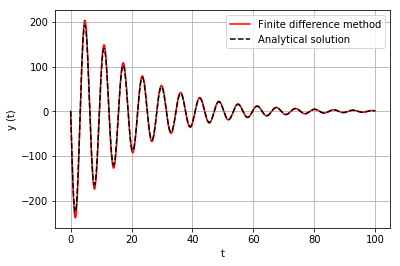

In [40]:
omega = 1.0 # undamped angular frequency of the oscillator
xi = 0.05 # damping ratio

a = 0.0
b = 100.0
n = 1000
p = lambda x: 1.0
q = lambda x: 2.0 * xi * omega
r = lambda x: omega**2
s = lambda x: 0.0
alpha = 0.0
beta = 1.0

# find numerical solution
t, y = finite_difference_method(a, b, n, p, q, r, s, alpha, beta)
print(y[0], y[-1])

# find analytical solution
A = np.zeros((2, 2), dtype=complex)
A[0][0] = np.exp(omega * a * (-xi + np.sqrt(xi**2 - 1.0 + 0.0j)))
A[0][1] = np.exp(omega * a * (-xi - np.sqrt(xi**2 - 1.0 + 0.0j)))
A[1][0] = np.exp(omega * b * (-xi + np.sqrt(xi**2 - 1.0 + 0.0j)))
A[1][1] = np.exp(omega * b * (-xi - np.sqrt(xi**2 - 1.0 + 0.0j)))
b = np.array((alpha, beta))
C = np.linalg.solve(A, b)
y_exact = C[0] * np.exp(omega * t * (-xi + np.sqrt(xi**2 - 1 + 0j))) + C[1] * np.exp(omega * t * (-xi - np.sqrt(xi**2 - 1 + 0j)))

# plot results
fig, ax = plt.subplots()
ax.plot(t, y, linestyle='-', color='red', label='Finite difference method')
ax.plot(t, y_exact.real, linestyle='--', color='black', label='Analytical solution')
ax.set_xlabel('t')
ax.set_ylabel('y (t)')
ax.legend()
ax.grid()

### Shooting method:

In [5]:
def newton_raphson(f, x0, h=1.0e-8, tol=1.0e-8, n_max=100):
    n = 0
    while n <= n_max:
        x1 = x0 - f(x0) / ((f(x0 + h) - f(x0)) / h)
        if f(x1) == 0 or abs(x1 - x0) < tol:
            return x1
        x0 = x1
        n += 1
    raise RuntimeError('no root found using', n_max, 'iterations')

In [34]:
def euler_system(f, g, a, b, n, y_0, z_0):
    x, h = np.linspace(a, b, n, retstep=True)
    y = np.zeros(n)
    z = np.zeros(n)
    y[0] = y_0
    z[0] = z_0
    for i in range(n-1):
        z[i+1] = z[i] + h * f(x[i], y[i], z[i])
        #y[i+1] = y[i] + h * g(x[i], y[i], z[i])
        y[i+1] = newton_raphson(lambda q: q - y[i] - h * g(x[i+1], q, z[i+1]), y[i])
    return x, y

In [46]:
def shooting_method(f, g, a, b, n, alpha, beta):
    """
    Solves 2nd order explicit ODE in the form y(x)'' = f(x, y(x), y(x)') in [a, b] with y(a) = alpha, y(b) = beta
    using shooting method.
    Args:
        f (function): function 
        g (function): function
        a (float): The left-most point of the interval
        b (float): The right-most point of the interval
        n (int): number of points dividing interval [a, b]
        alpha (float): initial value at x = a
        beta (float): initial value at x = b
    Returns:
        numpy.ndarray: Vector of grid-points
        numpy.ndarray: Vector of solution
    """
    def shooting_function(gamma):
        x, y = euler_system(f, g, a, b, n, alpha, gamma)
        return y[-1] - beta
    root = newton_raphson(shooting_function, 0.0)
    x, y = euler_system(f, g, a, b, n, alpha, root)
    return x, y

0.0 1.0


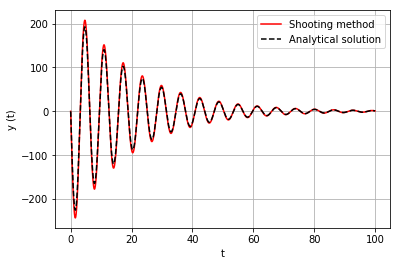

In [47]:
omega = 1.0 # undamped angular frequency of the oscillator
xi = 0.05 # damping ratio

def f(x, y, z):
    return -2.0 * xi * omega * z - y * omega**2

def g(x, y, z):
    return z

a = 0.0
b = 100.0
n = 5000
alpha = 0.0
beta = 1.0

# find numerical solution
t, y = shooting_method(f, g, a, b, n, alpha, beta)
print(y[0], y[-1])

# find analytical solution
A = np.zeros((2, 2), dtype=complex)
A[0][0] = np.exp(omega * a * (-xi + np.sqrt(xi**2 - 1.0 + 0.0j)))
A[0][1] = np.exp(omega * a * (-xi - np.sqrt(xi**2 - 1.0 + 0.0j)))
A[1][0] = np.exp(omega * b * (-xi + np.sqrt(xi**2 - 1.0 + 0.0j)))
A[1][1] = np.exp(omega * b * (-xi - np.sqrt(xi**2 - 1.0 + 0.0j)))
b = np.array((alpha, beta))
C = np.linalg.solve(A, b)
y_exact = C[0] * np.exp(omega * t * (-xi + np.sqrt(xi**2 - 1 + 0j))) + C[1] * np.exp(omega * t * (-xi - np.sqrt(xi**2 - 1 + 0j)))

# plot results
fig, ax = plt.subplots()
ax.plot(t, y, linestyle='-', color='red', label='Shooting method')
ax.plot(t, y_exact.real, linestyle='--', color='black', label='Analytical solution')
ax.set_xlabel('t')
ax.set_ylabel('y (t)')
ax.legend()
ax.grid()